In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
current_pwd = os.getcwd()

possible_paths = [
    '/home/export/soheuny/SRFinder/soheun/notebooks', 
    '/home/soheuny/HH4bsim/soheun/notebooks'
]
    
assert os.getcwd() in possible_paths, f"Did you change the path? It should be one of {possible_paths}"
os.chdir("..")

In [3]:
features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

In [4]:
import numpy as np
from events_data import EventsData
from dataset import SCDatasetInfo

def plot_sr_stats(events, sr_stats, ax, label, **plot_kwargs):
    assert len(events) == len(sr_stats)

    sr_stats_argsort = np.argsort(sr_stats)[::-1]
    weights = events.weights[sr_stats_argsort]
    is_signal = events.is_signal[sr_stats_argsort]
    is_4b = events.is_4b[sr_stats_argsort]

    ax.plot(
        np.cumsum(weights * is_4b) / np.sum(weights * is_4b),
        np.cumsum(weights * is_signal) / np.sum(weights * is_signal),           
        label=label,
        **plot_kwargs,
    )

def get_is_signal(scdinfo: SCDatasetInfo, signal_filename: str):
    # Now show the answer
    is_signals = []
    for file, file_len in zip(scdinfo.files, scdinfo.get_file_lengths()):
        is_signals.append(
            np.full(file_len, True)
            if file.name == signal_filename
            else np.full(file_len, False)
        )
    is_signal = np.concatenate(is_signals)
    return is_signal



def events_from_scdinfo(scdinfo: SCDatasetInfo, features: list, signal_filename: str) -> EventsData:
    df = scdinfo.fetch_data()
    df["signal"] = get_is_signal(scdinfo, signal_filename)
    events = EventsData.from_dataframe(df, features)

    return events

def hist_events_by_labels(events: EventsData, values: np.ndarray, bins, ax, **hist_kwargs):
    assert len(values) == len(events)   
    ax.hist(values[events.is_3b], 
                        bins=bins, histtype="step", label="3b", 
                        weights=events.weights[events.is_3b], 
                        **hist_kwargs)
    ax.hist(values[events.is_bg4b], 
                bins=bins, histtype="step", label="bg4b", 
                weights=events.weights[events.is_bg4b], 
                **hist_kwargs)
    ax.hist(values[events.is_signal], 
                bins=bins, histtype="step", label="signal", 
                weights=events.weights[events.is_signal], 
                **hist_kwargs)
    
    
def get_histogram_info(events_original: EventsData, values, bins, reweights):
    assert len(events_original) == len(values)

    if isinstance(bins, int):
        # calculate quantiles
        q = np.linspace(0, 1, bins + 1)
        bins = np.quantile(values, q)
        
    events_clone = events_original.clone()
    weights_rw = np.where(events_clone.is_4b, 1, reweights) * events_clone.weights
    weights_rw_sq = np.where(events_clone.is_4b, 1, reweights**2) * events_clone.weights
    
    hist_3b, _ = np.histogram(values[events_original.is_3b], bins=bins, 
                              weights=weights_rw[events_original.is_3b])
    hist_bg4b, _ = np.histogram(values[events_original.is_bg4b], bins=bins, 
                                weights=weights_rw[events_original.is_bg4b])
    hist_signal, _ = np.histogram(values[events_original.is_signal], bins=bins, 
                                  weights=weights_rw[events_original.is_signal])
    hist_4b, _ = np.histogram(values[events_original.is_4b], bins=bins, 
                              weights=weights_rw[events_original.is_4b])
    hist_3b_sq, _ = np.histogram(values[events_original.is_3b], bins=bins,
                                    weights=weights_rw_sq[events_original.is_3b])

    # std_est = np.sqrt((hist_3b + hist_4b) / 2)
    # is_sampled = std_est > 0
    
    std_est = np.sqrt(hist_4b + hist_3b_sq)
    is_sampled = std_est > 0
    sigma = (hist_4b - hist_3b)[is_sampled]  / std_est[is_sampled]
    sigma_avg = np.sqrt(np.mean(sigma**2))
    sigma_bg4b = (hist_bg4b - hist_3b)[is_sampled] / std_est[is_sampled]
    sigma_avg_bg4b = np.sqrt(np.mean(sigma_bg4b**2))
    df = np.sum(is_sampled)

    return {
        "hist_3b": hist_3b,
        "hist_bg4b": hist_bg4b,
        "hist_signal": hist_signal,
        "hist_4b": hist_4b,
        "std_est": std_est,
        "sigma": sigma,
        "sigma_avg": sigma_avg,
        "sigma_bg4b": sigma_bg4b,
        "sigma_avg_bg4b": sigma_avg_bg4b,
        "df": df,
    }

In [5]:
import torch
from fvt_classifier import FvTClassifier
from tst_info import TSTInfo
import yaml
import matplotlib.pyplot as plt

config_filename = "configs/counting_test_high_4b_in_CR.yml"


config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
ratio_4b = config["ratio_4b"]

hashes, hparams = TSTInfo.find({
    "experiment_name": experiment_name,
    "n_3b": n_3b,
    "ratio_4b": ratio_4b,
}, return_hparams=True)

seeds = np.unique([hp["seed"] for hp in hparams])
signal_ratios = np.unique([hp["signal_ratio"] for hp in hparams])
n_3bs = np.unique([hp["n_3b"] for hp in hparams])

tst_results = []
result_size = 0

In [6]:
import pandas as pd
from scipy import stats

pd.set_option('display.max_rows', 500)

n_3b = 140_0000
experiment_name = "counting_test_high_4b_in_CR"
tst_results_summary_df = pd.read_csv(f"./data/tsv/tst_results_summary_{experiment_name}_n_3b={n_3b}.tsv", sep="\t")

def get_p_value(row, deg_f):
    return stats.chi2.sf(deg_f * row**2, deg_f)


tst_results_summary_df["p_SR"] = get_p_value(tst_results_summary_df["sigma_avg_SR"], tst_results_summary_df["df_SR"])
tst_results_summary_df["p_bg4b_SR"] = get_p_value(tst_results_summary_df["sigma_avg_bg4b_SR"], tst_results_summary_df["df_SR"])
tst_results_summary_df["p_CR"] = get_p_value(tst_results_summary_df["sigma_avg_CR"], tst_results_summary_df["df_CR"])
tst_results_summary_df["p_bg4b_CR"] = get_p_value(tst_results_summary_df["sigma_avg_bg4b_CR"], tst_results_summary_df["df_CR"])

sig_level = 0.01
tst_results_summary_df["rejected_SR"] = tst_results_summary_df["p_SR"] < sig_level
tst_results_summary_df["rejected_bg4b_SR"] = tst_results_summary_df["p_bg4b_SR"] < sig_level
tst_results_summary_df["rejected_CR"] = tst_results_summary_df["p_CR"] < sig_level
tst_results_summary_df["rejected_bg4b_CR"] = tst_results_summary_df["p_bg4b_CR"] < sig_level

pd.set_option('display.max_rows', 500)
tst_results_summary_df.groupby(["signal_ratio", "nbin", "reweight"]).mean()

seed  sigma_avg_SR  sigma_avg_bg4b_SR  \
signal_ratio nbin reweight                                          
0.0          1    CR        25.0      3.582228           3.582228   
                  base      25.0      3.326207           3.326207   
             2    CR        25.0      2.790602           2.790602   
                  base      25.0      2.660259           2.660259   
             3    CR        25.0      2.408827           2.408827   
                  base      25.0      2.285141           2.285141   
             4    CR        25.0      2.176287           2.176287   
                  base      25.0      2.066021           2.066021   
             5    CR        25.0      2.015086           2.015086   
                  base      25.0      1.913512           1.913512   
             6    CR        25.0      1.890211           1.890211   
                  base      25.0      1.805579           1.805579   
             7    CR        25.0      1.785191           1.785191   
                  base      25.0      1.702095           1.702095   
             8    CR        25.0      1.756079           1.756079   
                  base      25.0      1.678369           1.678369   
             9    CR        25.0      1.672238           1.672238   
                  base      25.0      1.599594           1.599594   

                            sigma_avg_CR  sigma_avg_bg4b_CR  \
signal_ratio nbin reweight                                    
0.0          1    CR            4.360463           4.360463   
                  base          5.510183           5.510183   
             2    CR            4.568754           4.568754   
                  base          5.235363           5.235363   
             3    CR            4.248774           4.248774   
                  base          4.956666           4.956666   
             4    CR            4.031939           4.031939   
                  base          4.622240           4.622240   
             5    CR            3.781021           3.781021   
                  base          4.295360           4.295360   
             6    CR            3.591412           3.591412   
                  base          4.073645           4.073645   
             7    CR            3.413346           3.413346   
                  base          3.856664           3.856664   
             8    CR            3.248566           3.248566   
                  base          3.664315           3.664315   
             9    CR            3.107125           3.107125   
                  base          3.503404           3.503404   

                            initialize_with_fvt  df_SR  df_CR      p_SR  \
signal_ratio nbin reweight                                                
0.0          1    CR                        1.0    1.0    1.0  0.163831   
                  base                      1.0    1.0    1.0  0.118679   
             2    CR                        1.0    2.0    2.0  0.158999   
                  base                      1.0    2.0    2.0  0.100377   
             3    CR                        1.0    3.0    3.0  0.142887   
                  base                      1.0    3.0    3.0  0.128263   
             4    CR                        1.0    4.0    4.0  0.160210   
                  base                      1.0    4.0    4.0  0.126112   
             5    CR                        1.0    5.0    5.0  0.157758   
                  base                      1.0    5.0    5.0  0.149864   
             6    CR                        1.0    6.0    6.0  0.175214   
                  base                      1.0    6.0    6.0  0.158818   
             7    CR                        1.0    7.0    7.0  0.192631   
                  base                      1.0    7.0    7.0  0.174913   
             8    CR                        1.0    8.0    8.0  0.173593   
                  base                      1.0    8.0    8.0  0.153135   
             9    CR                

In [7]:
def get_sigma_avg_SR(signal_ratio, nbin, method):
    return tst_results_summary_df.groupby(["signal_ratio", "nbin", "reweight"]).get_group((signal_ratio, nbin, method))["sigma_avg_SR"].values

def get_p_SR(signal_ratio, nbin, method):
    return tst_results_summary_df.groupby(["signal_ratio", "nbin", "reweight"]).get_group((signal_ratio, nbin, method))["p_SR"].values

sigma1 = get_sigma_avg_SR(0.0, 5, "CR")
sigma2 = get_sigma_avg_SR(0.01, 5, "CR")
sigma3 = get_sigma_avg_SR(0.02, 5, "CR")

xmin = np.min(np.concatenate([sigma1, sigma2, sigma3]))
xmax = np.max(np.concatenate([sigma1, sigma2, sigma3]))
bins = np.linspace(xmin, xmax, 30)

plt.hist(sigma1, bins=bins, histtype="step", label="0.0")
plt.hist(sigma2, bins=bins, histtype="step", label="0.01")
plt.hist(sigma3, bins=bins, histtype="step", label="0.02")
plt.legend()
plt.show()

sigma1 = get_sigma_avg_SR(0.0, 5, "base")
sigma2 = get_sigma_avg_SR(0.01, 5, "base")
sigma3 = get_sigma_avg_SR(0.02, 5, "base")

xmin = np.min(np.concatenate([sigma1, sigma2, sigma3]))
xmax = np.max(np.concatenate([sigma1, sigma2, sigma3]))
bins = np.linspace(xmin, xmax, 30)

plt.hist(sigma1, bins=bins, histtype="step", label="0.0")
plt.hist(sigma2, bins=bins, histtype="step", label="0.01")
plt.hist(sigma3, bins=bins, histtype="step", label="0.02")
plt.legend()
plt.show()

sigma1 = get_sigma_avg_SR(0.02, 5, "CR")
sigma2 = get_sigma_avg_SR(0.02, 5, "base")

xmin = np.min(np.concatenate([sigma1, sigma2]))
xmax = np.max(np.concatenate([sigma1, sigma2]))
bins = np.linspace(xmin, xmax, 30)

plt.hist(sigma1, bins=bins, histtype="step", label="CR")
plt.hist(sigma2, bins=bins, histtype="step", label="base")
plt.legend()
plt.show()

sigma1 = get_sigma_avg_SR(0.0, 5, "CR")
sigma2 = get_sigma_avg_SR(0.0, 5, "base")

xmin = np.min(np.concatenate([sigma1, sigma2]))
xmax = np.max(np.concatenate([sigma1, sigma2]))
bins = np.linspace(xmin, xmax, 30)

plt.hist(sigma1, bins=bins, histtype="step", label="CR")
plt.hist(sigma2, bins=bins, histtype="step", label="base")
plt.legend()
plt.show()

p1 = get_p_SR(0.0, 5, "CR")
p2 = get_p_SR(0.01, 5, "CR")
p3 = get_p_SR(0.02, 5, "CR")

xmin = np.min(np.concatenate([p1, p2, p3]))
xmax = np.max(np.concatenate([p1, p2, p3]))
bins = np.linspace(xmin, xmax, 30)

plt.hist(p1, bins=bins, histtype="step", label="0.0")
plt.hist(p2, bins=bins, histtype="step", label="0.01")
plt.hist(p3, bins=bins, histtype="step", label="0.02")
plt.legend()
plt.show()

p1 = get_p_SR(0.0, 5, "base")
p2 = get_p_SR(0.01, 5, "base")
p3 = get_p_SR(0.02, 5, "base")

xmin = np.min(np.concatenate([p1, p2, p3]))
xmax = np.max(np.concatenate([p1, p2, p3]))
bins = np.linspace(xmin, xmax, 30)

plt.hist(p1, bins=bins, histtype="step", label="0.0")
plt.hist(p2, bins=bins, histtype="step", label="0.01")
plt.hist(p3, bins=bins, histtype="step", label="0.02")
plt.legend()
plt.show()

KeyError: (0.01, 5, 'CR')

1.9599639845400538


nbin  sigma_avg_SR  sigma_avg_bg4b_SR  \
signal_ratio seed reweight                                          
0.00         0    CR         1.0      0.508436           0.508436   
                  base       1.0      0.511660           0.511660   
             1    CR         1.0      3.229619           3.229619   
                  base       1.0      0.759856           0.759856   
             2    CR         1.0      4.000529           4.000529   
                  base       1.0      3.011712           3.011712   
0.01         0    CR         1.0      2.398912           5.109375   
                  base       1.0      3.442415           6.135276   
             1    CR         1.0      0.386191           3.404178   
                  base       1.0      3.691625           7.381697   
0.02         0    CR         1.0      7.923330           6.581985   
                  base       1.0      3.082053          15.884451   
             1    CR         1.0      9.977938           3.256720   
                  base       1.0      3.186649           9.228771   

                            sigma_avg_CR  sigma_avg_bg4b_CR  \
signal_ratio seed reweight                                    
0.00         0    CR            2.557318           2.557318   
                  base          3.717957           3.717957   
             1    CR            2.292809           2.292809   
                  base          1.944607           1.944607   
             2    CR            2.353555           2.353555   
                  base          0.540519           0.540519   
0.01         0    CR            2.972216           5.393964   
                  base          1.094663           1.341732   
             1    CR            1.785176           0.189984   
                  base          7.359668           9.294626   
0.02         0    CR            6.473315           4.856341   
                  base          1.773112           3.359784   
             1    CR            1.999085           0.056725   
                  base          1.060043           0.993028   

                            initialize_with_fvt  df_SR  df_CR  
signal_ratio seed reweight                                     
0.00         0    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0  
             1    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0  
             2    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0  
0.01         0    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0  
             1    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0  
0.02         0    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0  
             1    CR                        0.0    1.0    1.0  
                  base                      0.0    1.0    1.0

1793it [00:02, 732.29it/s]
  0%|          | 0/90 [00:00<?, ?it/s]

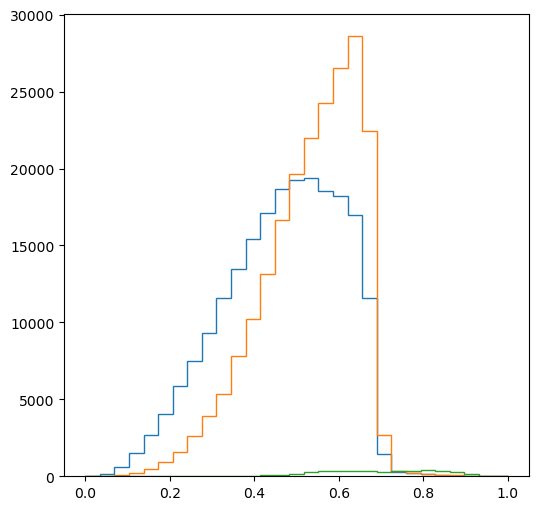

  1%|          | 1/90 [00:11<17:17, 11.66s/it]

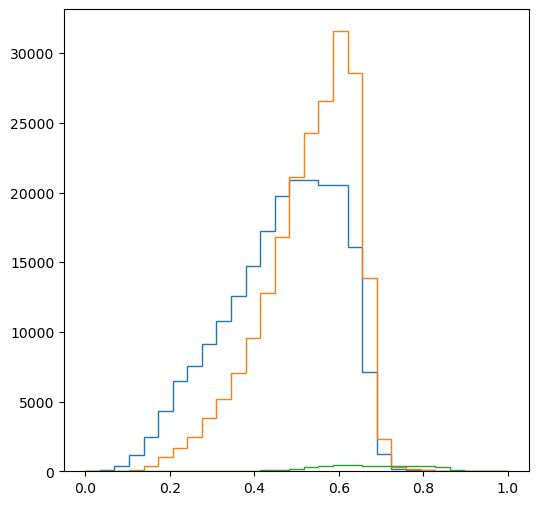

  2%|▏         | 2/90 [00:24<18:19, 12.49s/it]


KeyboardInterrupt: 

In [6]:
import sys
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

plt.rcParams["lines.markersize"] = 3

verbose = False
show_plots = False
hparam_filter = {
    "experiment_name": lambda x: x in ["counting_test_high_4b_in_CR"],
    "signal_ratio": 0.02,
}

experiment_name = "counting_test_high_4b_in_CR"
hashes = TSTInfo.find(hparam_filter, sort_by=["seed", "signal_ratio"])


for tstinfo_hash in (pbar := tqdm.tqdm(hashes)):
    
    tstinfo = TSTInfo.load(tstinfo_hash)
    signal_filename = tstinfo.hparams["signal_filename"]
    seed = tstinfo.hparams["seed"]
    signal_ratio = tstinfo.hparams["signal_ratio"]        
    experiment_name = tstinfo.hparams["experiment_name"]

    scdinfo_tst = tstinfo.scdinfo_tst
    events_tst = events_from_scdinfo(scdinfo_tst, features, signal_filename)
    
    base_fvt_hash = tstinfo.base_fvt_tinfo_hash
    fvt_model = FvTClassifier.load_from_checkpoint(f"./data/checkpoints/{base_fvt_hash}_best.ckpt")
    fvt_model.eval()
    
    events_tst.set_model_scores(fvt_model)
    CR_fvt_hash = tstinfo.CR_fvt_tinfo_hash
    CR_model = FvTClassifier.load_from_checkpoint(f"./data/checkpoints/{CR_fvt_hash}_best.ckpt")
    CR_model.eval()
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    bins = np.linspace(0, 1, 30)
    hist_events_by_labels(events_tst, events_tst.fvt_score, bins=bins, ax=ax)
    plt.show()


[rank: 0] Seed set to 42
[rank: 0] Seed set to 42
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | P

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

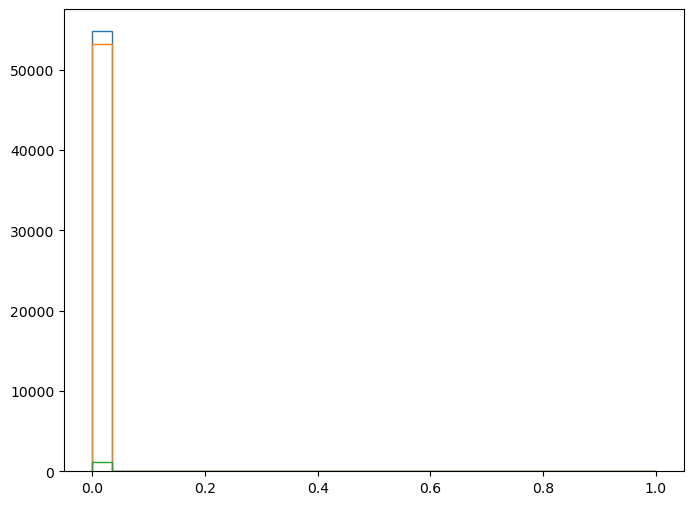

Epoch 0: 100%|██████████| 767/767 [00:18<00:00, 40.91it/s, v_num=72]       

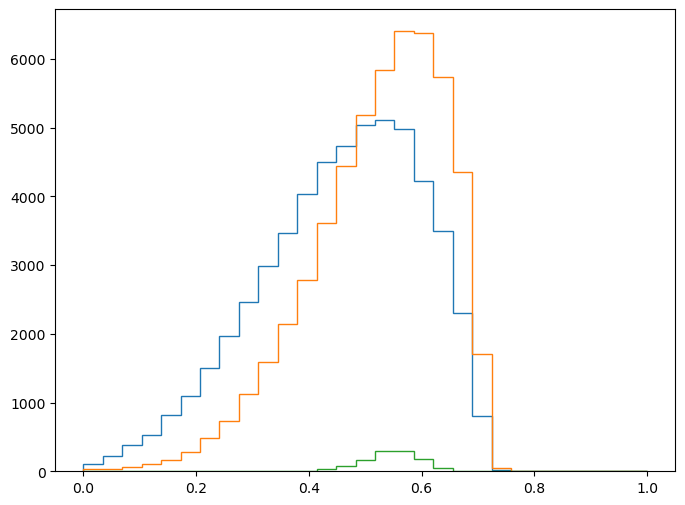

Epoch 1: 100%|██████████| 767/767 [00:20<00:00, 36.98it/s, v_num=72, val_loss=0.663, train_loss=0.669]

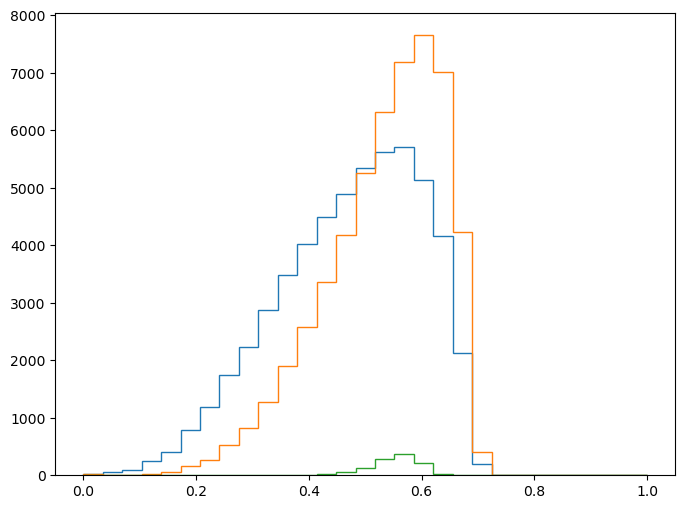

Epoch 2: 100%|██████████| 767/767 [00:19<00:00, 39.74it/s, v_num=72, val_loss=0.661, train_loss=0.663]

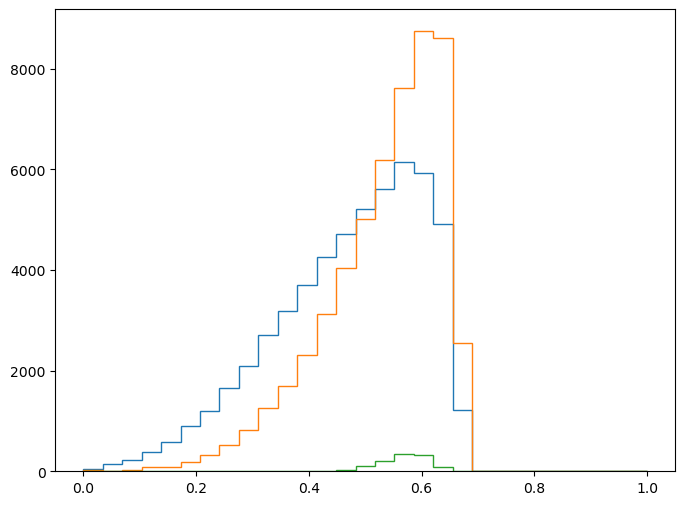

Epoch 3: 100%|██████████| 767/767 [00:19<00:00, 40.13it/s, v_num=72, val_loss=0.661, train_loss=0.662]

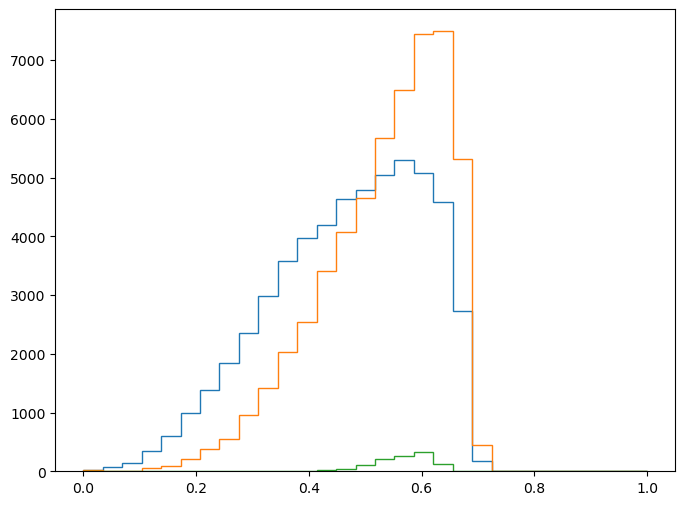

Epoch 4: 100%|██████████| 767/767 [00:19<00:00, 40.22it/s, v_num=72, val_loss=0.660, train_loss=0.662]

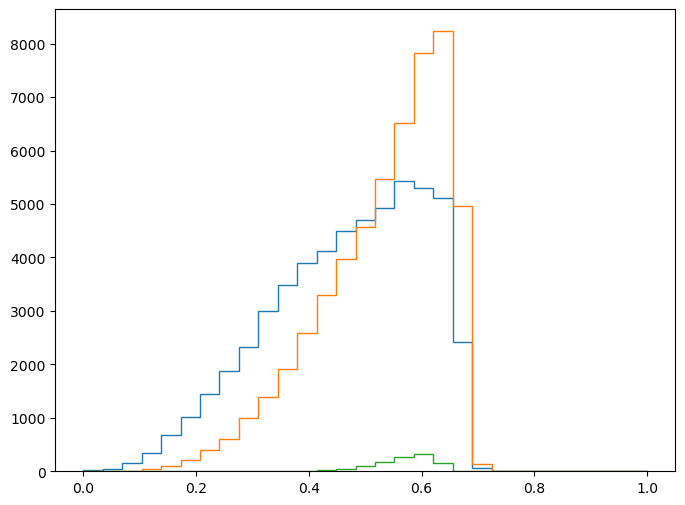

Epoch 5: 100%|██████████| 767/767 [00:19<00:00, 39.72it/s, v_num=72, val_loss=0.660, train_loss=0.662]

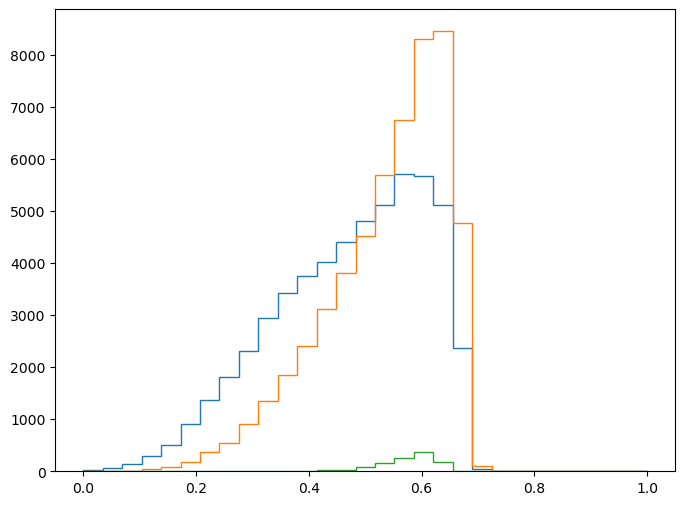

Epoch 6: 100%|██████████| 767/767 [00:20<00:00, 37.45it/s, v_num=72, val_loss=0.660, train_loss=0.662]

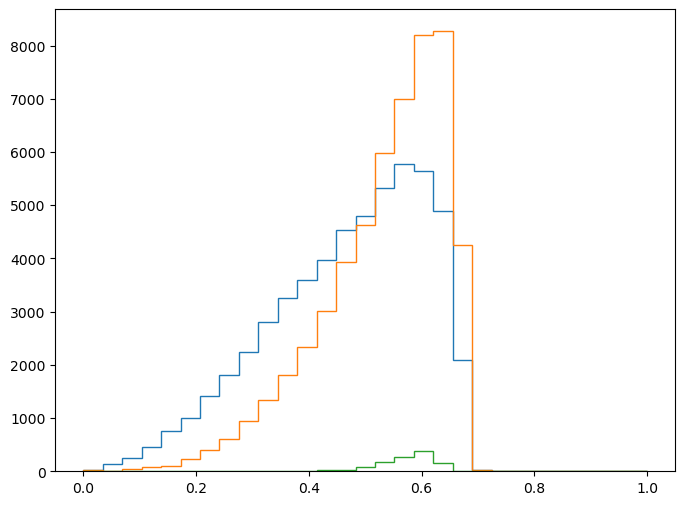

Epoch 7: 100%|██████████| 767/767 [00:19<00:00, 39.31it/s, v_num=72, val_loss=0.660, train_loss=0.661]

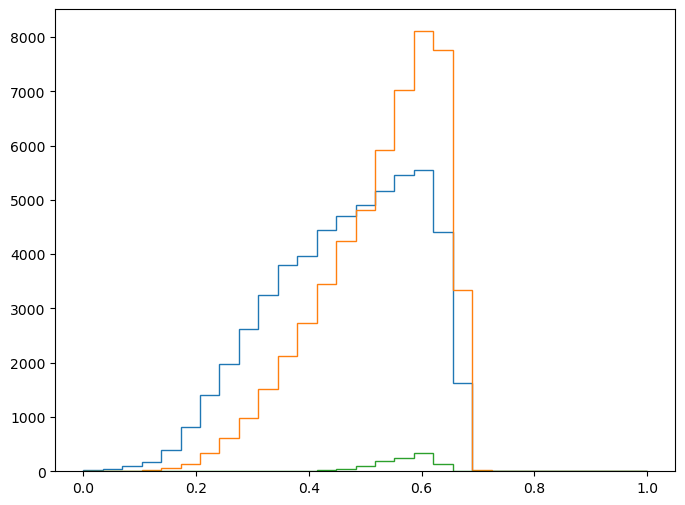

Epoch 8: 100%|██████████| 767/767 [00:19<00:00, 39.23it/s, v_num=72, val_loss=0.660, train_loss=0.661]

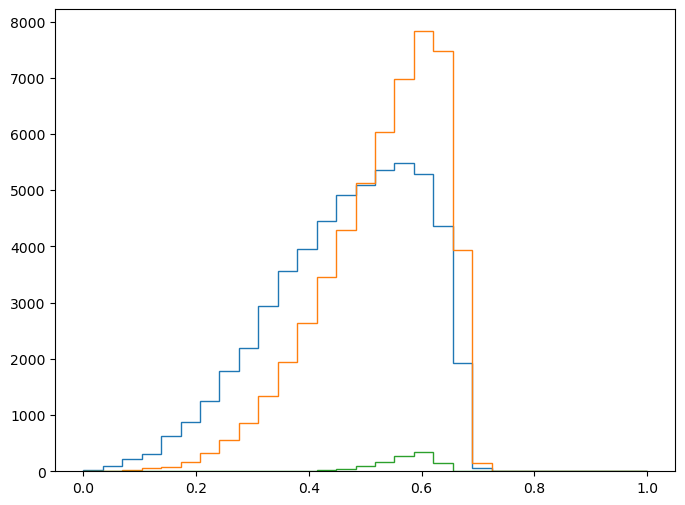

Epoch 9: 100%|██████████| 767/767 [00:18<00:00, 40.41it/s, v_num=72, val_loss=0.660, train_loss=0.661]

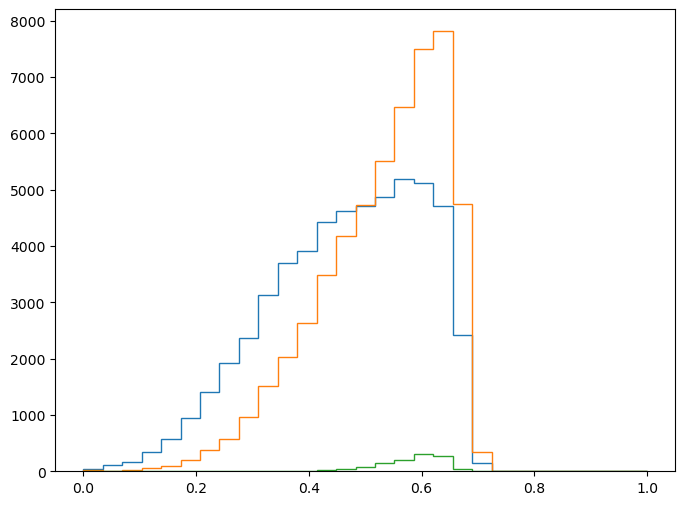

Epoch 10: 100%|██████████| 767/767 [00:18<00:00, 41.30it/s, v_num=72, val_loss=0.660, train_loss=0.661]

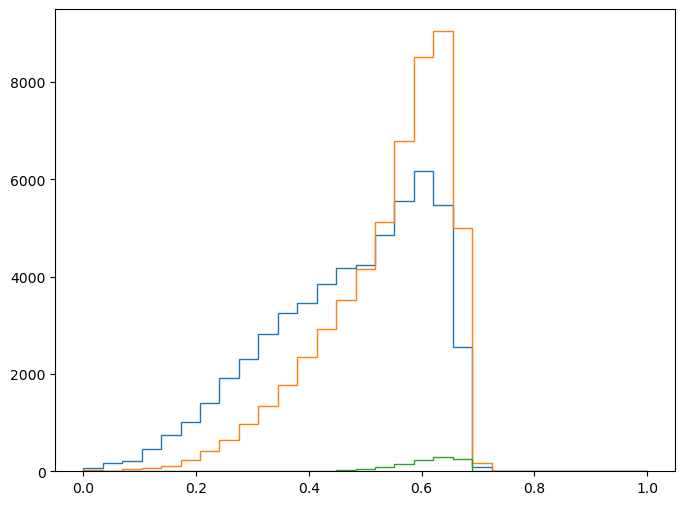

Epoch 11: 100%|██████████| 767/767 [00:18<00:00, 40.73it/s, v_num=72, val_loss=0.660, train_loss=0.661]

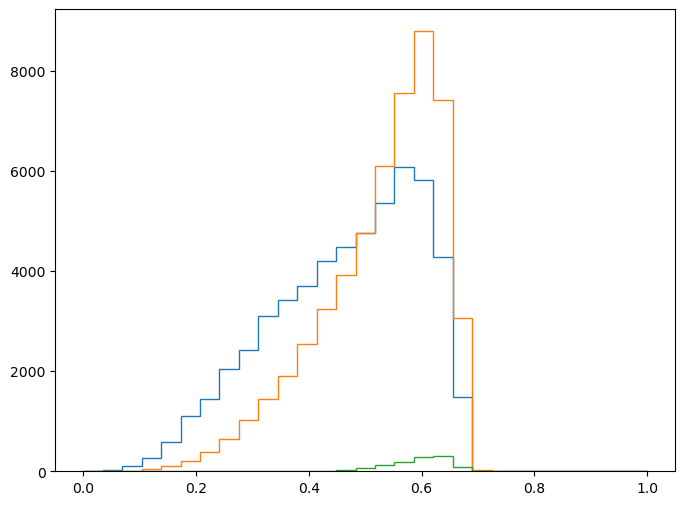

Epoch 12: 100%|██████████| 767/767 [00:19<00:00, 40.02it/s, v_num=72, val_loss=0.660, train_loss=0.660]

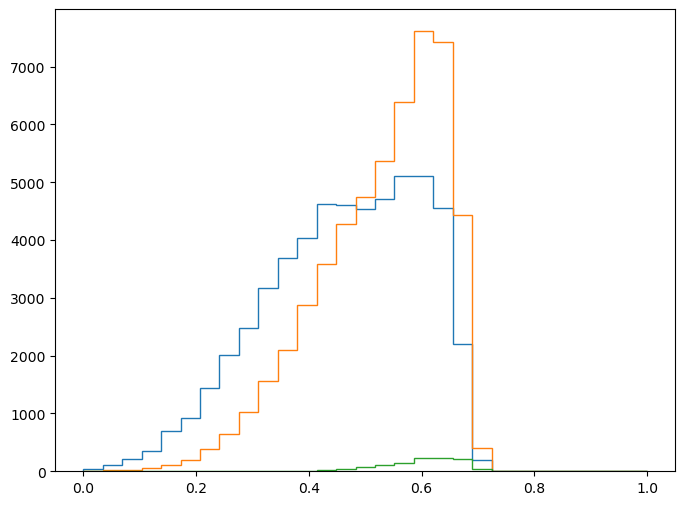

Epoch 13: 100%|██████████| 767/767 [00:19<00:00, 38.68it/s, v_num=72, val_loss=0.660, train_loss=0.661]

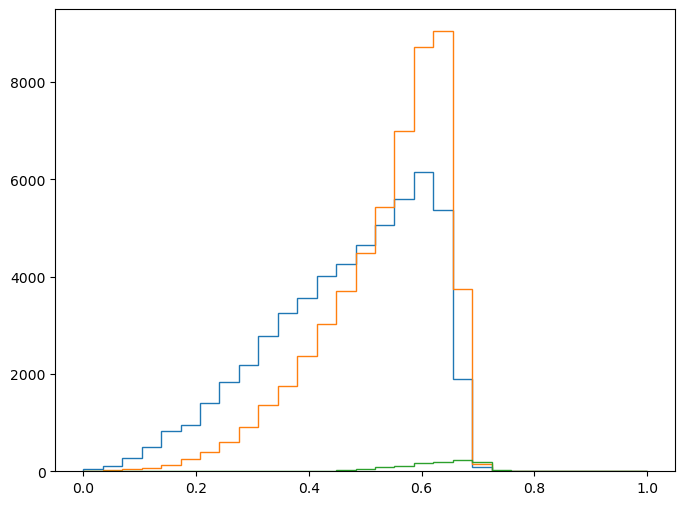

Epoch 14: 100%|██████████| 767/767 [00:19<00:00, 39.29it/s, v_num=72, val_loss=0.660, train_loss=0.660]

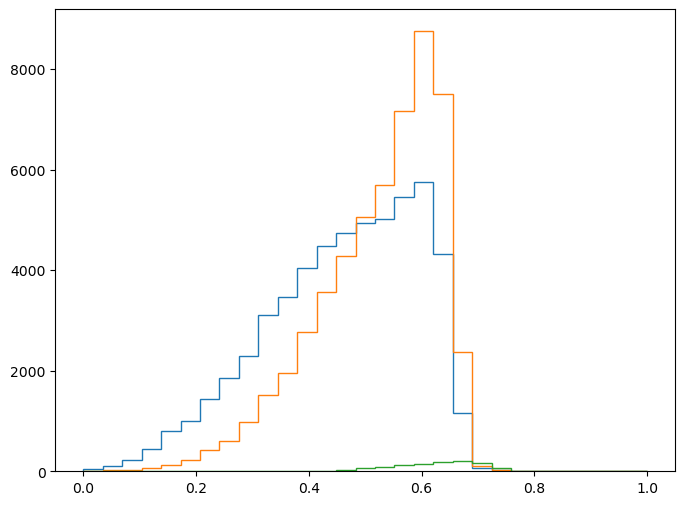

Epoch 15: 100%|██████████| 767/767 [00:19<00:00, 39.92it/s, v_num=72, val_loss=0.660, train_loss=0.660]

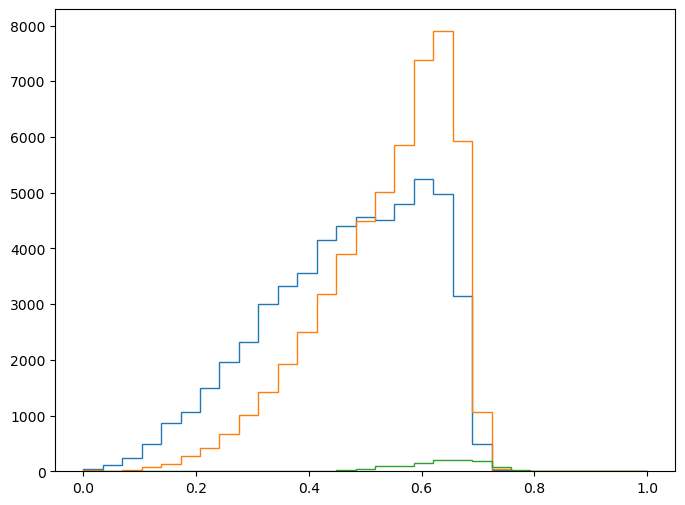

Epoch 16: 100%|██████████| 767/767 [00:19<00:00, 39.63it/s, v_num=72, val_loss=0.659, train_loss=0.660]

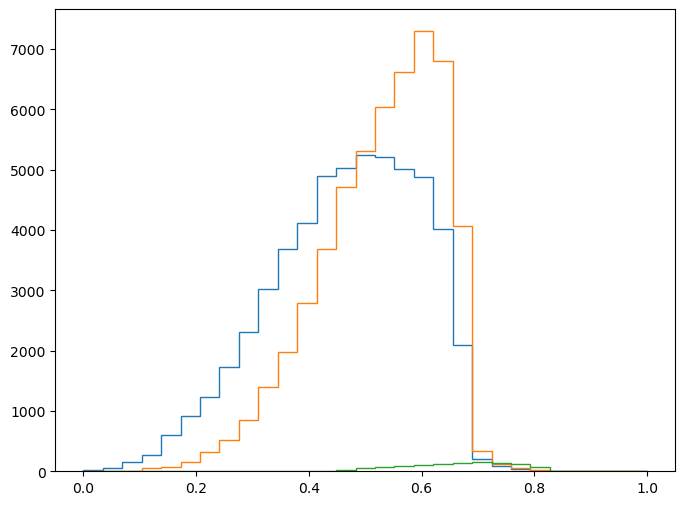

Epoch 17: 100%|██████████| 767/767 [00:20<00:00, 37.55it/s, v_num=72, val_loss=0.659, train_loss=0.660]

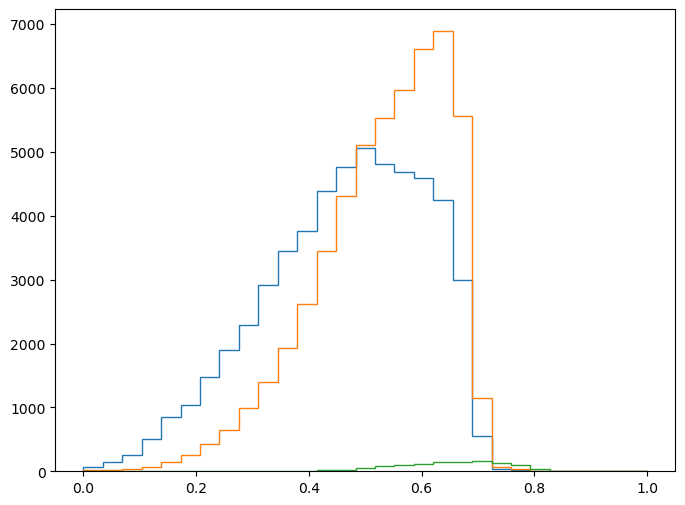

Epoch 18: 100%|██████████| 767/767 [00:18<00:00, 41.32it/s, v_num=72, val_loss=0.659, train_loss=0.660]

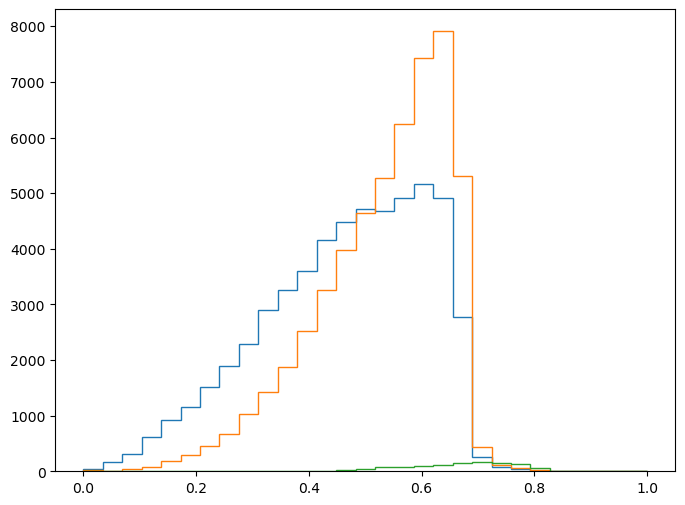

Epoch 19: 100%|██████████| 767/767 [00:19<00:00, 38.45it/s, v_num=72, val_loss=0.659, train_loss=0.660]

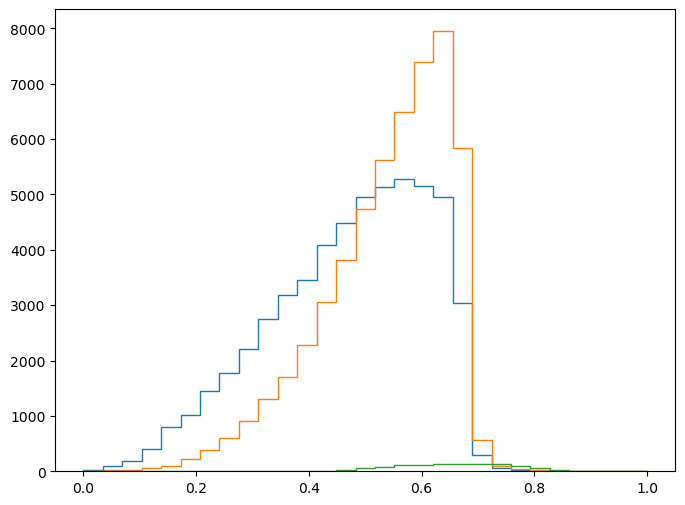

Epoch 20: 100%|██████████| 767/767 [00:20<00:00, 36.70it/s, v_num=72, val_loss=0.659, train_loss=0.660]

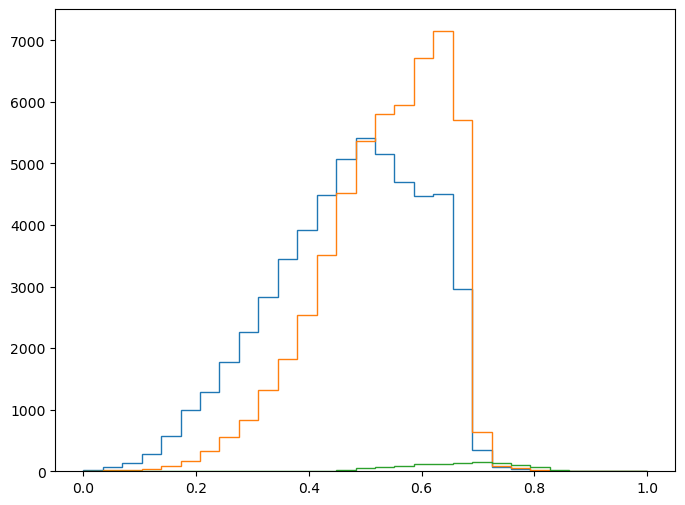

Epoch 21: 100%|██████████| 767/767 [00:19<00:00, 39.04it/s, v_num=72, val_loss=0.659, train_loss=0.660]

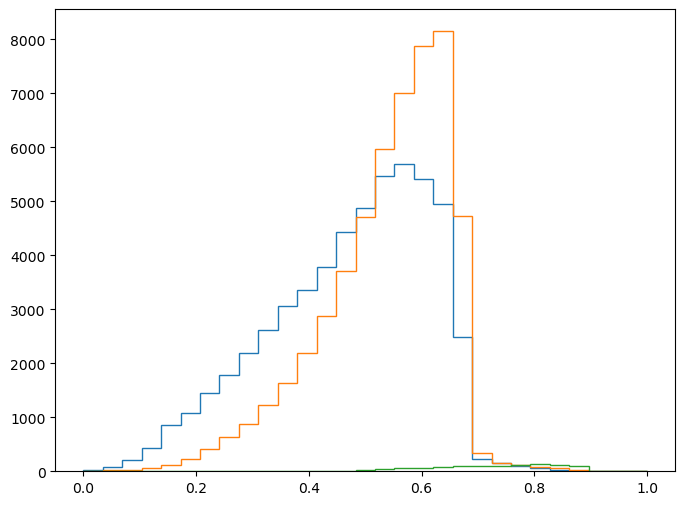

Epoch 22: 100%|██████████| 767/767 [00:18<00:00, 40.80it/s, v_num=72, val_loss=0.659, train_loss=0.660]

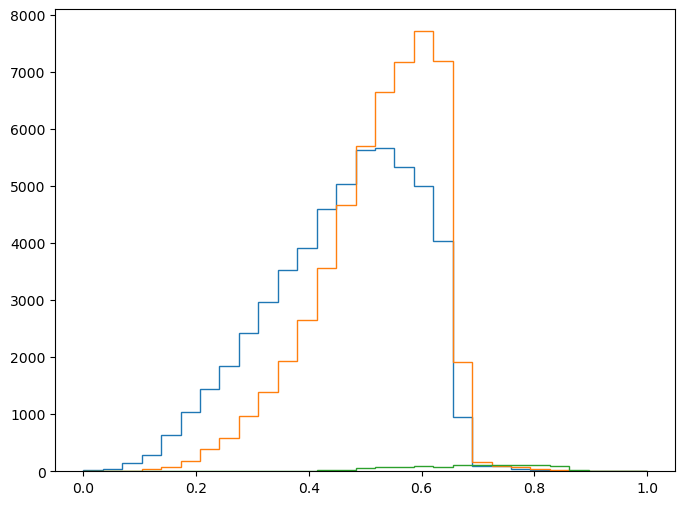

Epoch 23: 100%|██████████| 767/767 [00:19<00:00, 39.95it/s, v_num=72, val_loss=0.659, train_loss=0.659]

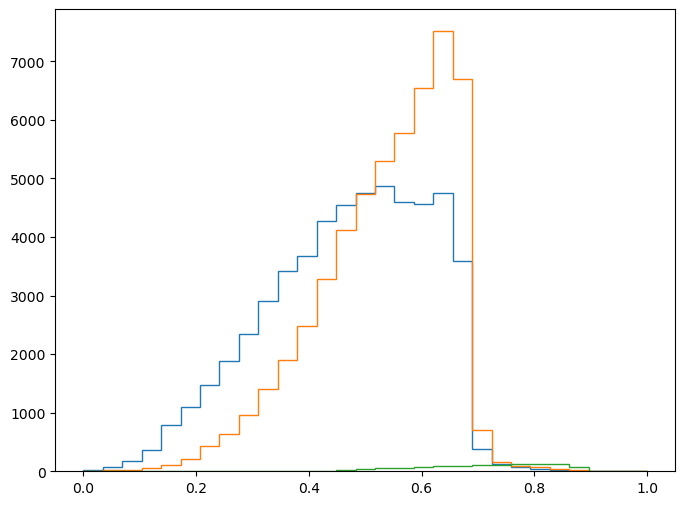

Epoch 24: 100%|██████████| 767/767 [00:18<00:00, 41.74it/s, v_num=72, val_loss=0.659, train_loss=0.659]

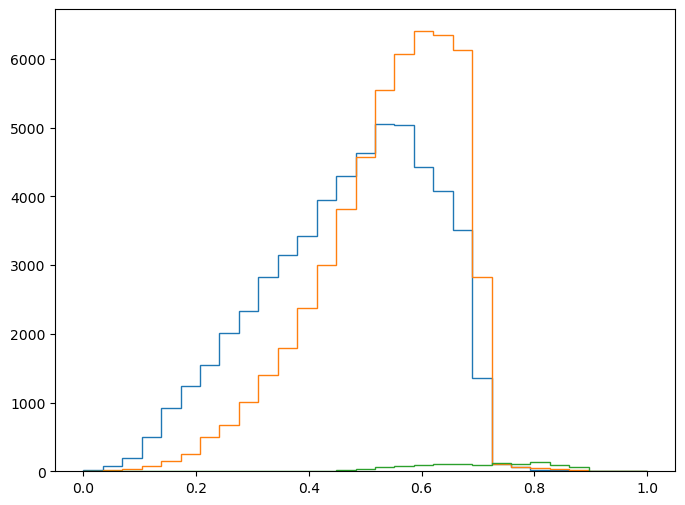

Epoch 25: 100%|██████████| 767/767 [00:18<00:00, 40.97it/s, v_num=72, val_loss=0.659, train_loss=0.659]

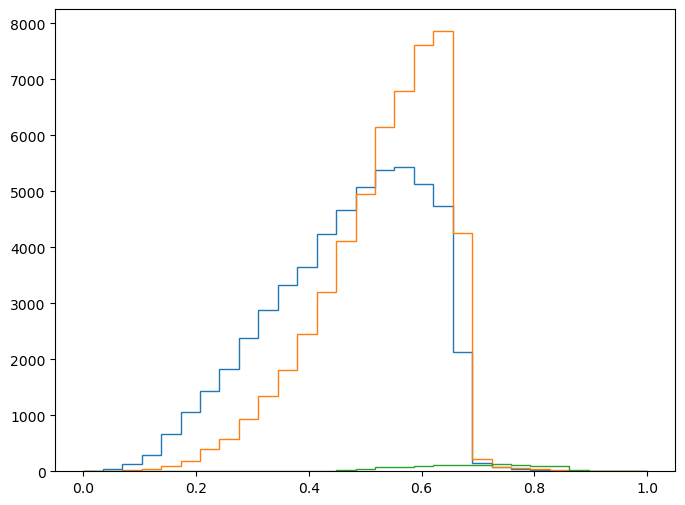

Epoch 26: 100%|██████████| 767/767 [00:17<00:00, 43.68it/s, v_num=72, val_loss=0.658, train_loss=0.659]

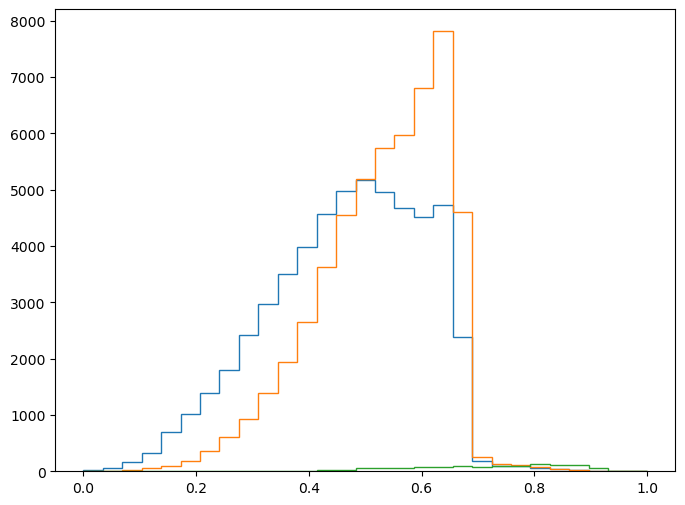

Epoch 27: 100%|██████████| 767/767 [00:19<00:00, 39.87it/s, v_num=72, val_loss=0.658, train_loss=0.659]

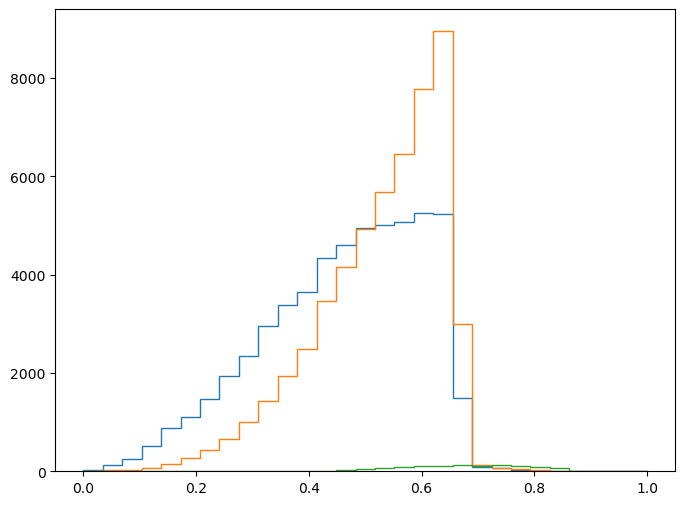

Epoch 28: 100%|██████████| 767/767 [00:17<00:00, 42.66it/s, v_num=72, val_loss=0.658, train_loss=0.659]

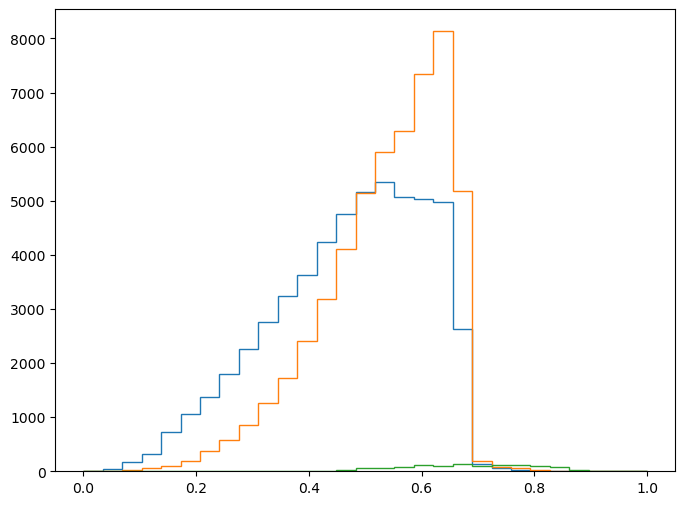

Epoch 29: 100%|██████████| 767/767 [00:17<00:00, 43.12it/s, v_num=72, val_loss=0.658, train_loss=0.659]

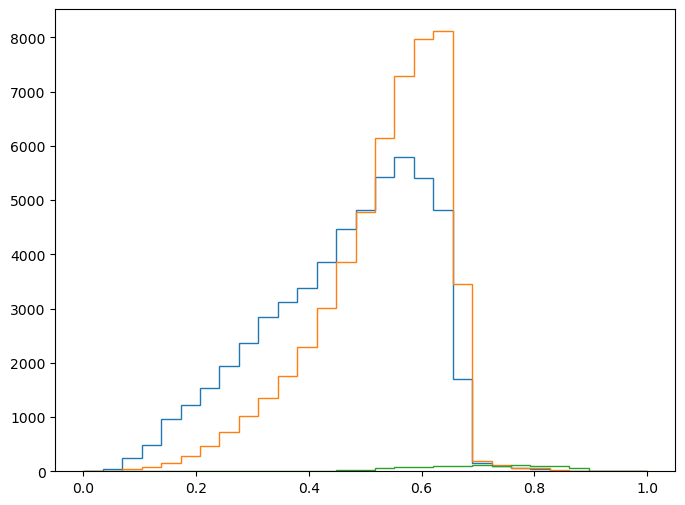

Epoch 29: 100%|██████████| 767/767 [00:25<00:00, 30.67it/s, v_num=72, val_loss=0.659, train_loss=0.659]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 767/767 [00:25<00:00, 30.62it/s, v_num=72, val_loss=0.659, train_loss=0.659]


FvTClassifier(
  (encoder): FvTEncoder(
    (canJetScaler): scaler()
    (dijetScaler): scaler()
    (quadjetScaler): scaler()
    (jetPtGBN): GhostBatchNorm1d()
    (jetEtaGBN): GhostBatchNorm1d()
    (jetMassGBN): GhostBatchNorm1d()
    (jetEmbed): conv1d(
      (module): Conv1d(4, 6, kernel_size=(1,), stride=(1,))
    )
    (dijetGBN): GhostBatchNorm1d()
    (dijetEmbed1): conv1d(
      (module): Conv1d(2, 6, kernel_size=(1,), stride=(1,))
    )
    (DijetResNetBlock): DijetResNetBlock(
      (reinforce1): DijetReinforceLayer(
        (conv): conv1d(
          (module): Conv1d(6, 6, kernel_size=(3,), stride=(3,), bias=False)
          (batchNorm): GhostBatchNorm1d()
        )
      )
      (convJ): conv1d(
        (module): Conv1d(6, 6, kernel_size=(1,), stride=(1,), bias=False)
        (batchNorm): GhostBatchNorm1d()
      )
      (reinforce2): DijetReinforceLayer(
        (conv): conv1d(
          (module): Conv1d(6, 6, kernel_size=(3,), stride=(3,))
        )
      )
    )
    (d

In [5]:
from dataset import generate_mother_dataset, split_scdinfo
import pytorch_lightning as pl
from training_info import TrainingInfoV2

from pl_callbacks import FvTScorePlotCallback

torch.set_float32_matmul_precision('medium')

dim_input_jet_features = 4
num_classes = 2

base_fvt_hparams = {
    "dim_dijet_features": 6,
    "dim_quadjet_features": 6,
    "lr": 1e-3,
    "batch_size": 1024,
    "max_epochs": 30,
    "train_seed": 42,
    "data_seed": 42,
    "val_ratio": 0.33,
    "fit_batch_size": True
}
base_fvt_train_ratio = 0.4

n_3b = 1400000
ratio_4b = 0.5
signal_ratio = 0.02
signal_filename = "HH4b_picoAOD.h5"
seed = 42


# 1. Generate the mother dataset
scdinfo_all, df_all = generate_mother_dataset(
    n_3b=n_3b,
    ratio_4b=ratio_4b,
    signal_ratio=signal_ratio,
    signal_filename=signal_filename,
    seed=seed,
)

# 2. Split the mother dataset into train and test
# Train -- validation split will be done by TrainingInfoV2

scdinfo_base_fvt, scdinfo_not_base_fvt = split_scdinfo(
    scdinfo_all, base_fvt_train_ratio, seed
)

pl.seed_everything(seed)
np.random.seed(seed)

base_fvt_tinfo = TrainingInfoV2(base_fvt_hparams, scdinfo_base_fvt)

base_fvt_train_dset, base_fvt_val_dset = (
    base_fvt_tinfo.fetch_train_val_tensor_datasets(
        features, "fourTag", "weight")
)

base_fvt_model = FvTClassifier(
    num_classes,
    dim_input_jet_features,
    base_fvt_hparams["dim_dijet_features"],
    base_fvt_hparams["dim_quadjet_features"],
    run_name="",
    device=torch.device("cuda:0"),
    lr=base_fvt_hparams["lr"],
)

events_rest = events_from_scdinfo(scdinfo_not_base_fvt, features, signal_filename)
events_rest.shuffle()
events_rest.trim(100_000)

base_fvt_model.fit(
    base_fvt_train_dset,
    base_fvt_val_dset,
    batch_size=base_fvt_hparams["batch_size"],
    max_epochs=base_fvt_hparams["max_epochs"],
    train_seed=base_fvt_hparams["train_seed"],
    save_checkpoint=False, 
    callbacks=[FvTScorePlotCallback(events_rest)],
)
base_fvt_model.eval()

[rank: 0] Seed set to 42
[rank: 0] Seed set to 42
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 81.60it/s]

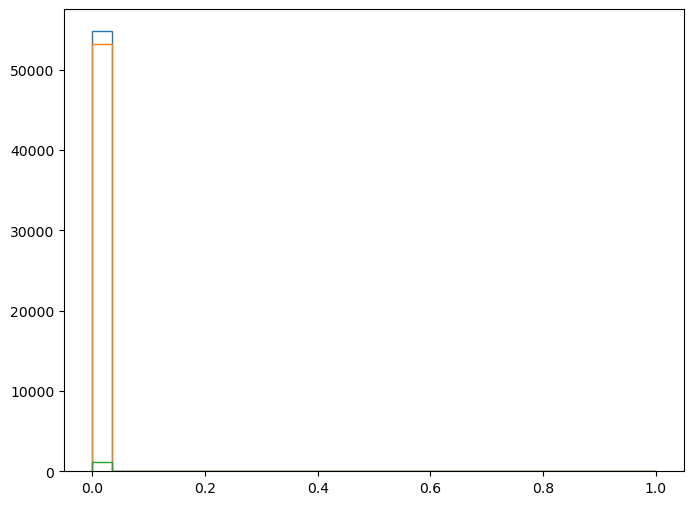

Epoch 0: 100%|██████████| 767/767 [00:17<00:00, 42.74it/s, v_num=76]       

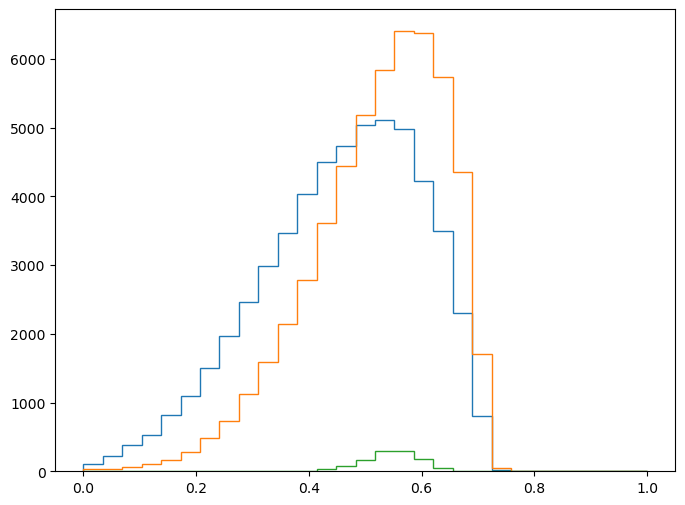

Epoch 0: 100%|██████████| 767/767 [00:25<00:00, 29.68it/s, v_num=76, val_loss=0.663]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 767/767 [00:25<00:00, 29.63it/s, v_num=76, val_loss=0.663]
Parameter containing:
tensor([0.9098], requires_grad=True)
Parameter containing:
tensor([[[-0.2415],
         [-0.1679],
         [-0.0941],
         [ 0.0346],
         [ 0.3155],
         [-0.1532]]], requires_grad=True)
Parameter containing:
tensor([[[ 0.1620],
         [-0.1958],
         [ 0.1929],
         [-0.0471],
         [-0.3854],
         [-0.2674]],

        [[-0.2456],
         [ 0.1842],
         [-0.2984],
         [ 0.0057],
         [ 0.0490],
         [-0.2730]]], requires_grad=True)


In [26]:
from dataset import generate_mother_dataset, split_scdinfo
import pytorch_lightning as pl
from training_info import TrainingInfoV2
from pl_callbacks import FvTScorePlotCallback


dim_input_jet_features = 4
num_classes = 2

base_fvt_hparams = {
    "dim_dijet_features": 6,
    "dim_quadjet_features": 6,
    "lr": 1e-3,
    "batch_size": 1024,
    "max_epochs": 1,
    "train_seed": 42,
    "data_seed": 42,
    "val_ratio": 0.33,
    "fit_batch_size": True
}
base_fvt_train_ratio = 0.4

n_3b = 1400000
ratio_4b = 0.5
signal_ratio = 0.02
signal_filename = "HH4b_picoAOD.h5"
seed = 42


# 1. Generate the mother dataset
scdinfo_all, df_all = generate_mother_dataset(
    n_3b=n_3b,
    ratio_4b=ratio_4b,
    signal_ratio=signal_ratio,
    signal_filename=signal_filename,
    seed=seed,
)

# 2. Split the mother dataset into train and test
# Train -- validation split will be done by TrainingInfoV2

scdinfo_base_fvt, scdinfo_not_base_fvt = split_scdinfo(
    scdinfo_all, base_fvt_train_ratio, seed
)

pl.seed_everything(seed)
np.random.seed(seed)

base_fvt_tinfo = TrainingInfoV2(base_fvt_hparams, scdinfo_base_fvt)

base_fvt_train_dset, base_fvt_val_dset = (
    base_fvt_tinfo.fetch_train_val_tensor_datasets(
        features, "fourTag", "weight")
)

base_fvt_model = FvTClassifier(
    num_classes,
    dim_input_jet_features,
    base_fvt_hparams["dim_dijet_features"],
    base_fvt_hparams["dim_quadjet_features"],
    run_name="",
    device=torch.device("cuda:0"),
    lr=base_fvt_hparams["lr"],
)

events_rest = events_from_scdinfo(scdinfo_not_base_fvt, features, signal_filename)
events_rest.shuffle()
events_rest.trim(100_000)

base_fvt_model.fit(
    base_fvt_train_dset,
    base_fvt_val_dset,
    batch_size=base_fvt_hparams["batch_size"],
    max_epochs=base_fvt_hparams["max_epochs"],
    train_seed=base_fvt_hparams["train_seed"],
    save_checkpoint=False, 
    callbacks=[FvTScorePlotCallback(events_rest)],
)

for i, p in enumerate(base_fvt_model.encoder.parameters()):
    if i == 0:
        print(p)
        
for i, p in enumerate(base_fvt_model.select_q.parameters()):
    if i == 0:
        print(p)

for i, p in enumerate(base_fvt_model.out.parameters()):
    if i == 0:
        print(p)

[rank: 0] Seed set to 42


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
24        Trainable params
920       Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 84.18it/s]

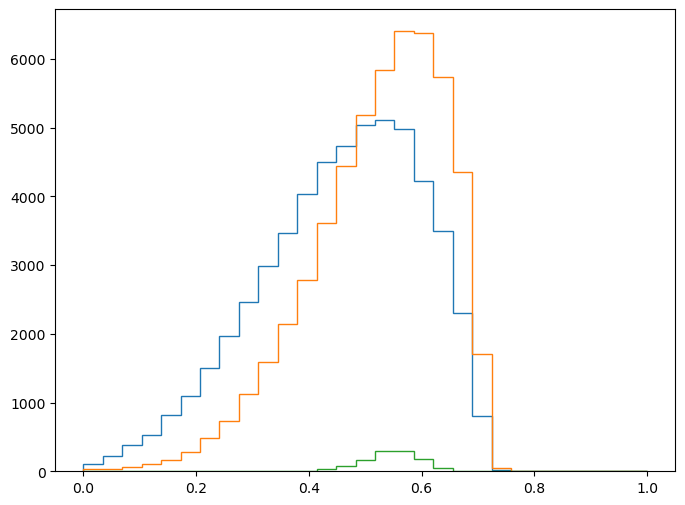

Epoch 0: 100%|██████████| 767/767 [00:13<00:00, 57.52it/s, v_num=77]       

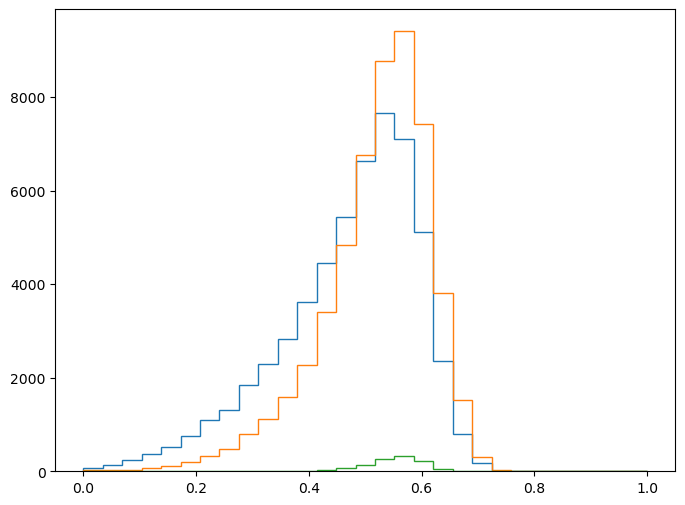

Epoch 0: 100%|██████████| 767/767 [00:21<00:00, 36.12it/s, v_num=77, val_loss=0.669]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 767/767 [00:21<00:00, 36.05it/s, v_num=77, val_loss=0.669]
Parameter containing:
tensor([0.9098])
Parameter containing:
tensor([[[-0.1129],
         [-0.5594],
         [-0.1573],
         [ 0.0007],
         [ 0.0563],
         [-0.1997]]], requires_grad=True)
Parameter containing:
tensor([[[ 0.1039],
         [-0.2641],
         [ 0.2741],
         [-0.0456],
         [-0.1925],
         [-0.3544]],

        [[-0.1801],
         [ 0.3002],
         [-0.3469],
         [-0.0174],
         [-0.0981],
         [-0.0872]]], requires_grad=True)


In [27]:
base_fvt_model.freeze_encoder()

base_fvt_model.fit(
    base_fvt_train_dset,
    base_fvt_val_dset,
    batch_size=base_fvt_hparams["batch_size"],
    max_epochs=base_fvt_hparams["max_epochs"],
    train_seed=base_fvt_hparams["train_seed"],
    save_checkpoint=False, 
    callbacks=[FvTScorePlotCallback(events_rest)],
)

for i, p in enumerate(base_fvt_model.encoder.parameters()):
    if i == 0:
        print(p)
        
for i, p in enumerate(base_fvt_model.select_q.parameters()):
    if i == 0:
        print(p)

for i, p in enumerate(base_fvt_model.out.parameters()):
    if i == 0:
        print(p)

# Power of Ensemble

In [7]:
from dataset import generate_mother_dataset, split_scdinfo
import pytorch_lightning as pl
from training_info import TrainingInfoV2
from pl_callbacks import FvTScorePlotCallback
from plots import calibration_plot


dim_input_jet_features = 4
num_classes = 2

base_fvt_hparams = {
    "dim_dijet_features": 6,
    "dim_quadjet_features": 6,
    "lr": 1e-3,
    "batch_size": 1024,
    "max_epochs": 30,
    "train_seed": 42,
    "data_seed": 42,
    "val_ratio": 0.33,
    "fit_batch_size": True
}
base_fvt_train_ratio = 0.5

n_3b = 100000
ratio_4b = 0.5
signal_ratio = 0.0
signal_filename = "HH4b_picoAOD.h5"
data_seed = 0
device = torch.device("cuda")


# 1. Generate the mother dataset
scdinfo_all, df_all = generate_mother_dataset(
    n_3b=n_3b,
    ratio_4b=ratio_4b,
    signal_ratio=signal_ratio,
    signal_filename=signal_filename,
    seed=data_seed,
)

# 2. Split the mother dataset into train and test
# Train -- validation split will be done by TrainingInfoV2

scdinfo_base_fvt, scdinfo_not_base_fvt = split_scdinfo(
    scdinfo_all, base_fvt_train_ratio, data_seed
)

events_other = events_from_scdinfo(scdinfo_not_base_fvt, features, signal_filename)

sigma_dicts = []
probs_4b_ests = []
for train_seed in range(10):
    pl.seed_everything(train_seed)
    np.random.seed(train_seed)
    
    base_fvt_hparams["train_seed"] = train_seed

    base_fvt_tinfo = TrainingInfoV2(base_fvt_hparams, scdinfo_base_fvt)

    base_fvt_train_dset, base_fvt_val_dset = (
        base_fvt_tinfo.fetch_train_val_tensor_datasets(
            features, "fourTag", "weight")
    )

    base_fvt_model = FvTClassifier(
        num_classes,
        dim_input_jet_features,
        base_fvt_hparams["dim_dijet_features"],
        base_fvt_hparams["dim_quadjet_features"],
        run_name="",
        device=torch.device("cuda:0"),
        lr=base_fvt_hparams["lr"],
    )

    base_fvt_model.fit(
        base_fvt_train_dset,
        base_fvt_val_dset,
        batch_size=base_fvt_hparams["batch_size"],
        max_epochs=base_fvt_hparams["max_epochs"],
        train_seed=base_fvt_hparams["train_seed"],
        save_checkpoint=False, 
        callbacks=[],
    )
    base_fvt_model.to(device)
    base_fvt_model.eval()
    
    probs_4b_ests.append(base_fvt_model.predict(events_other.X_torch).detach().cpu().numpy()[:, 1])
    probs_4b_est = np.mean(probs_4b_ests, axis=0)
    
    events_other_clone = events_other.clone()
    reweights = probs_4b_est / (1 - probs_4b_est) * (ratio_4b / (1 - ratio_4b))
    events_other_clone.reweight(
        np.where(events_other_clone.is_4b, 
                 events_other_clone.weights, 
                 events_other_clone.weights * reweights)
    )
    
    sigma_dict = {}
    
    for nbin in range(1, 10):
        q = np.linspace(0, 1, nbin + 1)
        bins = np.quantile(probs_4b_est, q)
        hist_3b, _ = np.histogram(probs_4b_est[events_other_clone.is_3b], bins=bins, 
                                  weights=events_other_clone.weights[events_other_clone.is_3b])
        hist_4b, _ = np.histogram(probs_4b_est[events_other_clone.is_4b], bins=bins, 
                                  weights=events_other_clone.weights[events_other_clone.is_4b])
        hist_3b_sq, _ = np.histogram(probs_4b_est[events_other_clone.is_3b], bins=bins, 
                                     weights=(reweights * events_other_clone.weights)[events_other_clone.is_3b])
        sigma = (hist_4b - hist_3b) / np.sqrt(hist_4b + hist_3b_sq)
        sigma_avg = np.sqrt(np.mean(sigma**2))
        sigma_dict[nbin] = sigma_avg
        
    print(sigma_dict)
        
    sigma_dicts.append(sigma_dict)

KeyboardInterrupt: 

In [12]:
from matplotlib.gridspec import GridSpec

def get_sigma_avg(events: EventsData, hist_values: np.ndarray, bins, reweights: np.ndarray):
    hist_3b, _ = np.histogram(hist_values[events.is_3b], bins=bins, 
                                weights=events.weights[events.is_3b])
    hist_4b, _ = np.histogram(hist_values[events.is_4b], bins=bins, 
                                weights=events.weights[events.is_4b])
    hist_3b_sq, _ = np.histogram(hist_values[events.is_3b], bins=bins, 
                                weights=(events.weights * reweights)[events.is_3b])
    sigma = (hist_4b - hist_3b) / np.sqrt(hist_4b + hist_3b_sq)
    sigma_avg = np.sqrt(np.mean(sigma**2))
    
    return sigma_avg

def plot_reweighted_samples(events_reweighted: EventsData, 
                            events_not_reweighted: EventsData,
                            hist_values: np.ndarray, 
                            fig: plt.Figure):
    gs = GridSpec(2, 2, figure=fig)
    for ax_cnt, quantile in enumerate([True, False]):
        if quantile:
            q = np.linspace(0, 1, 10)
            bins = np.quantile(hist_values, q)
        else:
            bins = np.linspace(np.min(hist_values), np.max(hist_values), 10)

        ax = fig.add_subplot(gs[ax_cnt, 0])
        hist_events_by_labels(events_reweighted, hist_values, bins=bins, ax=ax)
        ax.set_title("Reweighted")
        ax.legend()
        ax = fig.add_subplot(gs[ax_cnt, 1])
        hist_events_by_labels(events_not_reweighted, hist_values, bins=bins, ax=ax)
        ax.set_title("NOT Reweighted")
        ax.legend()

[rank: 0] Seed set to 0
[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 14: 100%|██████████| 163/163 [00:07<00:00, 22.57it/s, v_num=162, val_loss=0.693, train_loss=0.693]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 9: 100%|██████████| 40/40 [00:03<00:00, 12.26it/s, avg_val_loss=0.694]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 40/40 [00:03<00:00, 12.26it/s, avg_val_loss=0.694]


[rank: 0] Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 11: 100%|██████████| 75/75 [00:04<00:00, 16.06it/s, v_num=163, val_loss=0.694, train_loss=0.693]


/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


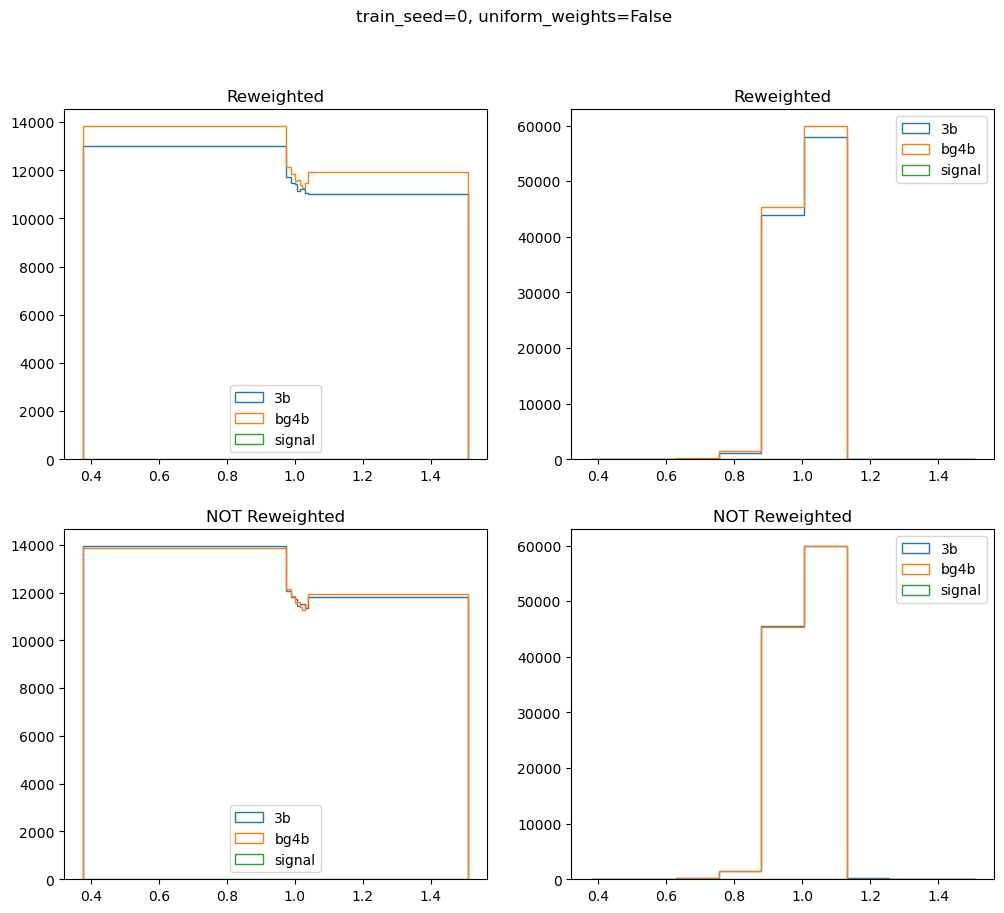

Reweighted / Quantile bins
3.1322153
NOT Reweighted / Quantile bins
0.69253975
Reweighted / Uniform bins
4.2084446
NOT Reweighted / Uniform bins
2.5421636


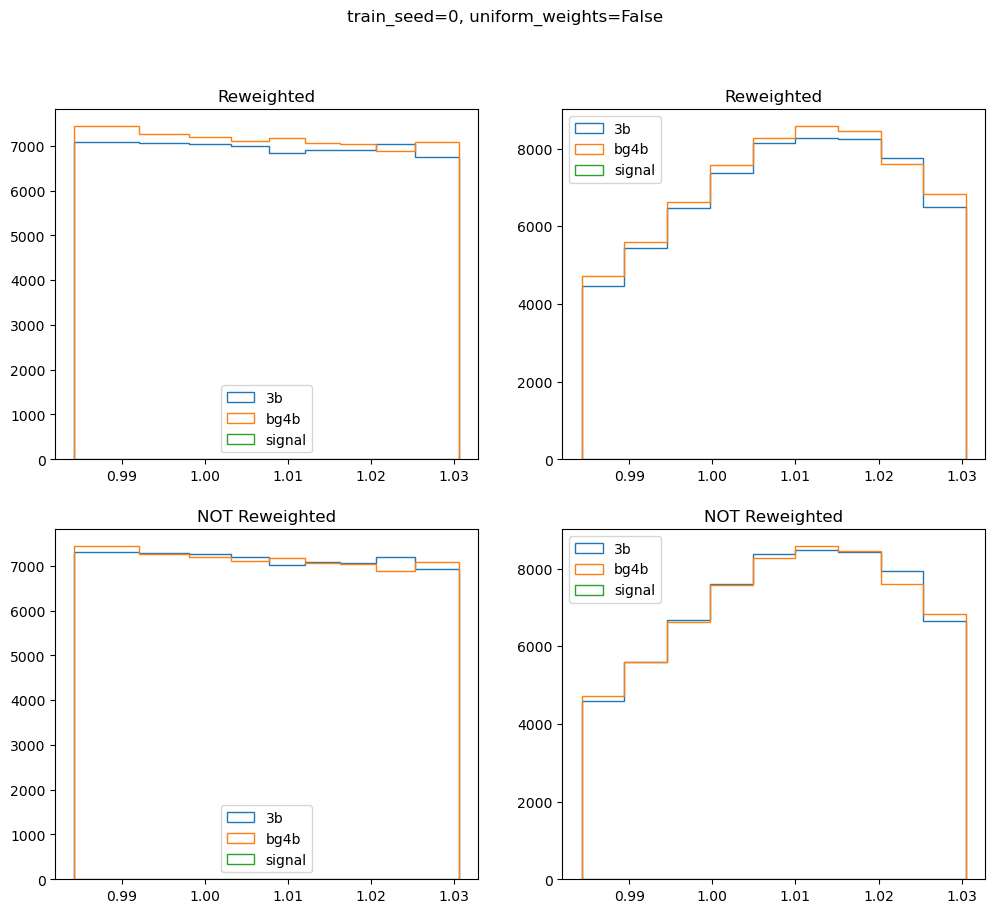

Reweighted / Quantile bins
1.8367217
NOT Reweighted / Quantile bins
1.0838562
Reweighted / Uniform bins
1.9819622
NOT Reweighted / Uniform bins
1.2269522


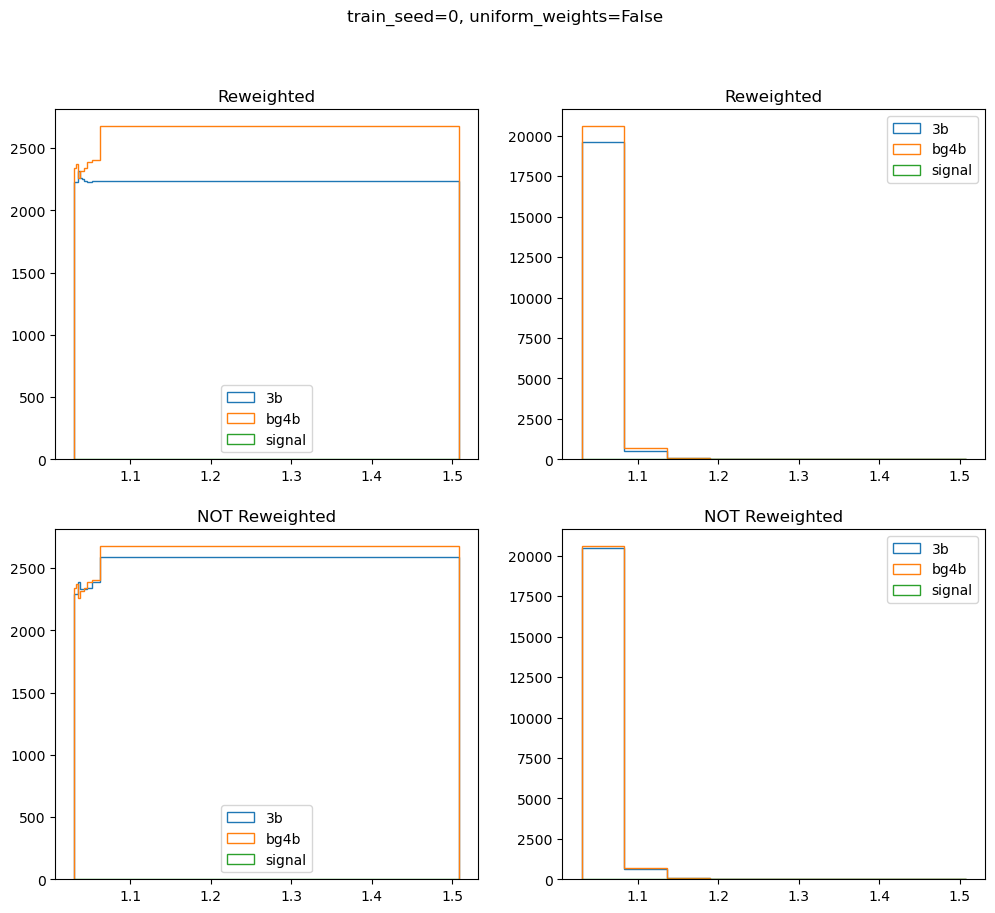

[rank: 0] Seed set to 0
[rank: 0] Seed set to 0
/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/export/soheuny/.conda/envs/coffea_torch/lib/py ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Reweighted / Quantile bins
2.78934
NOT Reweighted / Quantile bins
1.260783
Reweighted / Uniform bins
2.6614523
NOT Reweighted / Uniform bins
1.3853121


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 6:   0%|          | 0/163 [00:00<?, ?it/s, v_num=164, val_loss=0.693, train_loss=0.693]          

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f252975bf60>
Traceback (most recent call last):
  File "/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/export/soheuny/.conda/envs/coffea_torch/lib/python3.11/multiprocessing/connection.py", line 948, in wai

Epoch 11:   0%|          | 0/163 [00:00<?, ?it/s, v_num=164, val_loss=0.693, train_loss=0.693]          

In [19]:
from dataset import generate_mother_dataset, split_scdinfo
import pytorch_lightning as pl
from training_info import TrainingInfoV2
from pl_callbacks import FvTScorePlotCallback
from plots import calibration_plot
from signal_region import get_SR_stats
import itertools
# import gridspec




dim_input_jet_features = 4
num_classes = 2


base_fvt_hparams = {
    "dim_dijet_features": 6,
    "dim_quadjet_features": 6,
    "lr": 1e-3,
    "batch_size": 1024,
    "max_epochs": 30,
    "train_seed": 42,
    "data_seed": 42,
    "val_ratio": 0.33,
    "fit_batch_size": True
}
base_fvt_train_ratio = 0.5
SR_train_ratio = 0.25

n_3b = 500_000
ratio_4b = 0.5
signal_ratio = 0.0
signal_filename = "HH4b_picoAOD.h5"
data_seed = 0
device = torch.device("cuda")

train_seeds = [0, 1]
nbins = range(1, 11)


# 1. Generate the mother dataset
scdinfo_all, df_all = generate_mother_dataset(
    n_3b=n_3b,
    ratio_4b=ratio_4b,
    signal_ratio=signal_ratio,
    signal_filename=signal_filename,
    seed=data_seed,
)

# Remove 4b events
df_all = df_all.iloc[:n_3b]
# give random "fourTag" labels
np.random.seed(data_seed)
df_all["fourTag"] = np.random.choice([0, 1], size=n_3b, p=[1 - ratio_4b, ratio_4b])
df_all["signal"] = False
df_all_uniform_weights = df_all.copy()
df_all_uniform_weights["weight"] = 1

fake_sigma_dicts = []
fake_probs_4b_ests = []
fake_SR_stats = []

for train_seed in train_seeds:
    for uniform_weights in [False, True]:
        
        if uniform_weights:
            events_all = EventsData.from_dataframe(df_all_uniform_weights, features)
        else:
            events_all = EventsData.from_dataframe(df_all, features)
            
        events_train, events_other = events_all.split(base_fvt_train_ratio, seed=data_seed)
        events_SR_train, events_tst = events_other.split(SR_train_ratio, seed=data_seed)
        
        pl.seed_everything(train_seed)
        np.random.seed(train_seed)
        
        base_fvt_hparams["train_seed"] = train_seed
        
        events_train, events_val = events_train.split(1 - base_fvt_hparams["val_ratio"], seed=train_seed)
        events_train.fit_batch_size(base_fvt_hparams["batch_size"])
        events_val.fit_batch_size(base_fvt_hparams["batch_size"])
        
        base_fvt_train_dset = events_train.to_tensor_dataset()
        base_fvt_val_dset = events_val.to_tensor_dataset()
        
        base_fvt_model = FvTClassifier(
            num_classes,
            dim_input_jet_features,
            base_fvt_hparams["dim_dijet_features"],
            base_fvt_hparams["dim_quadjet_features"],
            run_name="",
            device=torch.device("cuda:0"),
            lr=base_fvt_hparams["lr"],
        )

        base_fvt_model.fit(
            base_fvt_train_dset,
            base_fvt_val_dset,
            batch_size=base_fvt_hparams["batch_size"],
            max_epochs=base_fvt_hparams["max_epochs"],
            train_seed=base_fvt_hparams["train_seed"],
            save_checkpoint=False, 
            callbacks=[],
        )
        base_fvt_model.to(device)
        base_fvt_model.eval()
        
        fake_SR_stat = get_SR_stats(
            events_tst,
            fvt_model=base_fvt_model,
            method="smearing",
            events_SR_train=events_SR_train,
            noise_scale=0.1,
        )
        fake_SR_stats.append(fake_SR_stat)
        
        fake_probs_4b_est = base_fvt_model.predict(events_other.X_torch).detach().cpu().numpy()[:, 1]
        fake_probs_4b_ests.append(fake_probs_4b_est)
        
        SR_stats_argsort = np.argsort(fake_SR_stat)[::-1]
        SR_stats_sorted = fake_SR_stat[SR_stats_argsort]

        weights = events_tst.weights[SR_stats_argsort]
        is_4b = events_tst.is_4b[SR_stats_argsort]
        cumul_4b_ratio = np.cumsum(weights * is_4b) / np.sum(weights * is_4b)

        w_4b_SR_ratio = 0.2
        w_4b_CR_ratio = 0.8

        SR_cut, CR_cut = None, None
        for i in range(1, len(cumul_4b_ratio)):
            if cumul_4b_ratio[i] > w_4b_SR_ratio and SR_cut is None:
                SR_cut = SR_stats_sorted[i - 1]
            if cumul_4b_ratio[i] > w_4b_CR_ratio and CR_cut is None:
                CR_cut = SR_stats_sorted[i - 1]
            if SR_cut is not None and CR_cut is not None:
                break

        # If the cut is not found, set the cut to the minimum value
        # Both SR and CR cuts should be different
        if SR_cut is None:
            SR_cut = SR_stats_sorted[-1]
        if CR_cut is None:
            CR_cut = SR_stats_sorted[-1]
        if SR_cut == CR_cut:
            raise ValueError("SR and CR cuts are the same")

        SR_idx = fake_SR_stat >= SR_cut
        events_tst_SR = events_tst[SR_idx]

        CR_idx = (fake_SR_stat >= CR_cut) & (fake_SR_stat < SR_cut)
        events_tst_CR = events_tst[CR_idx]
        
        events_CR_train, events_CR_val = events_tst_CR.split(1 - base_fvt_hparams["val_ratio"], seed=train_seed)
        events_CR_train.fit_batch_size(base_fvt_hparams["batch_size"])
        events_CR_val.fit_batch_size(base_fvt_hparams["batch_size"])
        
        CR_fvt_train_dset = events_CR_train.to_tensor_dataset()
        CR_fvt_val_dset = events_CR_val.to_tensor_dataset()
        
        CR_fvt_model = FvTClassifier(
            num_classes,
            dim_input_jet_features,
            base_fvt_hparams["dim_dijet_features"],
            base_fvt_hparams["dim_quadjet_features"],
            run_name="",
            device=torch.device("cuda:0"),
            lr=base_fvt_hparams["lr"],
        )
        
        CR_fvt_model.fit(
            CR_fvt_train_dset,
            CR_fvt_val_dset,
            batch_size=base_fvt_hparams["batch_size"],
            max_epochs=base_fvt_hparams["max_epochs"],
            train_seed=base_fvt_hparams["train_seed"],
            save_checkpoint=False,
            callbacks=[],
        )
        CR_fvt_model.to(device)
        CR_fvt_model.eval()
        
        fake_probs_4b_est_CR = CR_fvt_model.predict(events_tst.X_torch).detach().cpu().numpy()[:, 1]
        events_tst_clone = events_tst.clone()
        reweights = fake_probs_4b_est_CR / (1 - fake_probs_4b_est_CR) * (ratio_4b / (1 - ratio_4b))
        events_tst_clone.reweight(
            np.where(events_tst_clone.is_4b, 
                    events_tst_clone.weights, 
                    events_tst_clone.weights * reweights)
        )
        
        fake_sigma_dict = {}
        
        for nbin, quantile, reweighted, region in itertools.product(nbins, 
                                                                    [True, False], 
                                                                    [True, False], 
                                                                    ["all", "CR", "SR"]):
            
            if region == "all":
                region_idx = np.ones_like(fake_SR_stat, dtype=bool)
            elif region == "CR":
                region_idx = CR_idx
            elif region == "SR":
                region_idx = SR_idx
            else:
                raise ValueError("Invalid region")
            
            if quantile:
                q = np.linspace(0, 1, nbin + 1)
                bins = np.quantile(fake_SR_stat[region_idx], q)
            else:
                bins = np.linspace(np.min(fake_SR_stat[region_idx]), np.max(fake_SR_stat[region_idx]), nbin)
                
            if reweighted:
                sigma_avg = get_sigma_avg(events_tst_clone[region_idx], 
                                          fake_SR_stat[region_idx], 
                                          bins, 
                                          reweights[region_idx])
            else:
                sigma_avg = get_sigma_avg(events_tst[region_idx], 
                                          fake_SR_stat[region_idx], 
                                          bins, 
                                          reweights=1)
        
            fake_sigma_dict[(uniform_weights, reweighted, region, quantile, nbin)] = sigma_avg

        fake_sigma_dicts.append(fake_sigma_dict)
            
        
        fig = plt.figure(figsize=(12, 10))
        fig.suptitle(f"train_seed={train_seed}, uniform_weights={uniform_weights}, All")
        plot_reweighted_samples(events_tst_clone, events_tst, fake_SR_stat, fig)
        plt.show()
        plt.close()
        print("Reweighted / Quantile bins")
        print(fake_sigma_dict[(uniform_weights, True, "all", True, 10)])
        print("NOT Reweighted / Quantile bins")
        print(fake_sigma_dict[(uniform_weights, False, "all", True, 10)])
        print("Reweighted / Uniform bins")
        print(fake_sigma_dict[(uniform_weights, True, "all", False, 10)])
        print("NOT Reweighted / Uniform bins")
        print(fake_sigma_dict[(uniform_weights, False, "all", False, 10)])
        
        fig = plt.figure(figsize=(12, 10))
        fig.suptitle(f"train_seed={train_seed}, uniform_weights={uniform_weights}, Control Region")
        plot_reweighted_samples(events_tst_clone[CR_idx], events_tst[CR_idx], fake_SR_stat[CR_idx], fig)
        plt.show()
        plt.close()
        print("Reweighted / Quantile bins")
        print(fake_sigma_dict[(uniform_weights, True, "CR", True, 10)])
        print("NOT Reweighted / Quantile bins")
        print(fake_sigma_dict[(uniform_weights, False, "CR", True, 10)])
        print("Reweighted / Uniform bins")
        print(fake_sigma_dict[(uniform_weights, True, "CR", False, 10)])
        print("NOT Reweighted / Uniform bins")
        print(fake_sigma_dict[(uniform_weights, False, "CR", False, 10)])
        
        fig = plt.figure(figsize=(12, 10))
        fig.suptitle(f"train_seed={train_seed}, uniform_weights={uniform_weights}, Signal Region")
        plot_reweighted_samples(events_tst_clone[SR_idx], events_tst[SR_idx], fake_SR_stat[SR_idx], fig)
        plt.show()
        plt.close()
        print("Reweighted / Quantile bins")
        print(fake_sigma_dict[(uniform_weights, True, "SR", True, 10)])
        print("NOT Reweighted / Quantile bins")
        print(fake_sigma_dict[(uniform_weights, False, "SR", True, 10)])
        print("Reweighted / Uniform bins")
        print(fake_sigma_dict[(uniform_weights, True, "SR", False, 10)])
        print("NOT Reweighted / Uniform bins")
        print(fake_sigma_dict[(uniform_weights, False, "SR", False, 10)])